# Introduction to Bayesian Optimization.
### Bayesian optimization is a sequential design strategy for global optimization of black-box functions that doesn't require derivatives.

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.datasets import mnist
from sklearn.model_selection import StratifiedKFold

# Evaluation of the model
from sklearn.model_selection import KFold

MAX_EVALS = 500
N_FOLDS = 10

Using TensorFlow backend.


# Create a function to take parameters and return a compiled NN 

In [2]:
#Early stopping after 10 epochs of little decrease in our loss function.
early_stopper = EarlyStopping(patience=10)
def create_and_compile(network):
    """Network is a dictionary"""
    input_shape = (784,)
    nb_layers = network['nb_layers']
    nb_neurons = network['nb_neurons']
    activation = network['activation']
    optimizer = network['optimizer']
    #learning_rate = network['learning_rate'] TODO figure out how to add learning rate to an activation function
    #Define the type of model
    #A Sequential model, is a series of fully connected (DENSE) layers that are connected in sequence.
    model = Sequential()
    model.add(Dense(nb_neurons, activation=activation, input_shape=input_shape, name='input_layer'))
    model.add(Dropout(rate=0.2, name='dropout_input'))
    for i in range(nb_layers):
        model.add(Dense(nb_neurons, activation=activation, name='layer_{}'.format(i+1)))
        #Dropout to help avoid over-fitting
        model.add(Dropout(rate=0.2, name='dropout_{}'.format(i+1)))
    # Output layer.
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    return model

# Define our Cross validation function
This is the function that we want to use to optimize towards. Typically you "one hot encode" your target to be a vector of records, N_classes. But since the Kfolds cross validation needs to take a single volumn vector, we will one hot encode the values AFTER we split our data.

In [3]:
def cross_validate(model,X=None,y=None,num_fold=5):
    kFold = StratifiedKFold(n_splits=5)
    generator = kFold.split(X, y)
    Y_train = np_utils.to_categorical(y, 10)
    scores = []
    for val in generator:
        model.fit(x=X[val[0]], y=Y_train[val[0]], batch_size=512,
                  validation_data = [X[val[1]],Y_train[val[1]]],
                  epochs=100, verbose=0, callbacks = [early_stopper])
        scores.append(model.evaluate(X[val[1]],Y_train[val[1]]))
    return np.array(scores)[:,1].mean() # 1 is accuracy, 0 is loss

In [4]:
#Read in the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Plot the y label to see the distribution

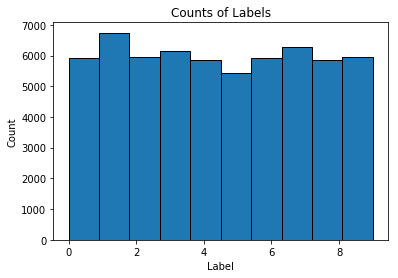

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.hist(y_train[:], edgecolor = 'k'); 
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Counts of Labels');

In [6]:
# let's print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

# building the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)
Train matrix shape (60000, 784)
Test matrix shape (10000, 784)


In [13]:
from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer

In [12]:
from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer

start = timer()
network = {'nb_layers':1, 'nb_neurons':784, 'activation':'relu','optimizer':'adam'}
model = create_and_compile(network)
results = cross_validate(model, X_train, y_train)
train_time = timer() - start

print('The baseline score on the test set is {:.4f}.'.format(results))
print('The baseline training time is {:.4f} seconds'.format(train_time))

11996/11996 [==============================] - 1s 94us/step
The baseline score on the test set is 0.9935.
The baseline training time is 70.1870 seconds


In [7]:
import csv
import sys
from hyperopt import STATUS_OK

def objective(params, n_folds = 5):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    sys.stdout.flush()
    start = timer()
    #When using Hyperpot to generate our lists, it creates them as floats, to we are converting them to
    #integers so that they will work on our Neural Network
    for parameter_name in ['nb_neurons', 'nb_layers']:
        params[parameter_name] = int(params[parameter_name])
    #Create and compile our network, from the parameters that the TPE choses. 
    model = create_and_compile(params)
    #Generate the accuracy of the parameters
    cv_results = cross_validate(model,X_train, y_train)
    #This allows us to keep track of how long it takes to run the 5 fold CV on our NN.
    #This is important if we need to make comprimises on speed VS accuracy.
    #The more nodes/layers that you have, the longer it takes for the NN to train/run
    run_time = timer() - start
    
    # We take 1 - our accuracy to get how far away our model is from 100% accuracy. 
    loss = 1 - cv_results

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([cv_results, params, ITERATION, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

# Pick the type of optimization algorithm

We are using the TPE which is TREE Parzen Estimator. 
    The Tree-structured Parzen Estimator builds a model by applying Bayes rule. Instead of directly representing p( y | x) instead it used Bayes rule. Which is p (Y|X) = P(X|Y) * P(Y) / P(X)

In [8]:
from hyperopt import tpe
from hyperopt import Trials
from hyperopt import fmin
from hyperopt import hp

# optimization algorithm
tpe_algorithm = tpe.suggest

# Keep track of results
bayes_trials = Trials()

In [9]:
# Define the search space
space = {
    'nb_layers': hp.quniform('nb_layers', 1,5, 1), #Layers from 1-5, incrementing by 1
    'nb_neurons': hp.quniform('nb_neurons', 64, 1024, 64), #NB neurons from 64-1024, incrementing by 64
    'activation': hp.choice('activation', ['relu', 'elu', 'tanh', 'sigmoid']), #Chose one of the 4 activations functions for the layers
    'optimizer': hp.choice('optimizer', ['rmsprop', 'adam', 'sgd', 'adagrad',
                      'adadelta', 'adamax', 'nadam']) #Chose one of the 7 optimizers
}

In [10]:
#Here we can see what a random sample from our space looks like
from hyperopt.pyll.stochastic import sample
sample(space)

{'activation': 'tanh',
 'nb_layers': 4.0,
 'nb_neurons': 256.0,
 'optimizer': 'rmsprop'}

In [11]:
# File to save first results
out_file = './neural_network.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['accuracy', 'params', 'iteration', 'train_time'])
of_connection.close()

In [14]:
%%capture

# Global variable
global  ITERATION
ITERATION = 0
# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = 50, trials = bayes_trials, rstate = np.random.RandomState(50))

In [16]:
data = pd.read_csv('neural_network.csv')

In [20]:
data[data['accuracy']==max(data['accuracy'])]

,accuracy,params,iteration,train_time
49,0.996401,"{'activation': 'relu', 'nb_layers': 3, 'nb_neu...",50,102.410144


In [21]:
data.sort_values('accuracy', ascending=False)

,accuracy,params,iteration,train_time
49,0.996401,"{'activation': 'relu', 'nb_layers': 3, 'nb_neu...",50,102.410144
31,0.996085,"{'activation': 'relu', 'nb_layers': 3, 'nb_neu...",32,51.653945
32,0.995868,"{'activation': 'relu', 'nb_layers': 3, 'nb_neu...",33,46.819381
37,0.995785,"{'activation': 'relu', 'nb_layers': 5, 'nb_neu...",38,101.954635
33,0.995768,"{'activation': 'relu', 'nb_layers': 3, 'nb_neu...",34,42.850932
39,0.995752,"{'activation': 'relu', 'nb_layers': 3, 'nb_neu...",40,46.352520
29,0.995752,"{'activation': 'relu', 'nb_layers': 2, 'nb_neu...",30,30.873281
23,0.995601,"{'activation': 'tanh', 'nb_layers': 1, 'nb_neu...",24,32.251612
28,0.995568,"{'activation': 'relu', 'nb_layers': 2, 'nb_neu...",29,30.348787
45,0.995452,"{'activation': 'relu', 'nb_layers': 3, 'nb_neu...",46,35.124397
